# Transfer Learning

Here we take an existing CNN model which has been trained on a large dataset(millions of images) like ImageNet and then we use this model's Convolution layers to extract features from our dataset containing less number of images(some thousands or hundreds of images) to extract good quality features from our small dataset and then add a custom Neural Network in front of it which is specific to our problem and just train this Neural network in place of training the whole CNN model.

Here to make sure that the convolution layers are not changed during the backpropagation, we lock the layers and keep the Dense layers unlocked. Thus during backpropagation, the loss is back-propagated to only the dense layers and not the convolution layers.

Somtimes, we would like to not lock all the convolution layers, because the convoltuion layers near the Flattern layer will be very specific to the dataset on which this Open Model was trained. So in such cases, with some trial and error and visualizing the model's feature map we can decide which layers to lock and which to keep unlocked so that the needed layers get adjusted according to our problem.

## Approach

Here the approach is composed of the following steps:
- Download the prefered model's weights
- Load the prefered model's skeleton
- Load the weights into the skeleton so that the model is now complete
- Lock the desired layers
- Take the layer from where you want to add your changes
- Add the layers that you want after the above chosen layer
    - Here we will use the Funtional API rather than the Sequential API
    - Make sure you add the Flatten and Dense layers if the chosen layer is a Convolution Layer
- Once the last Dense layer has been added to the modified model, create a model object
- Compile the model
- Fit the model

## The Example

### Download the Prefered Model

In [3]:
!mkdir -p dataset/inception
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \-O dataset/inception/inception_v3.h5

--2020-10-29 14:36:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:80e::2010, 2404:6800:4009:80c::2010, 2404:6800:4009:80b::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:80e::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘dataset/inception/inception_v3.h5’

dataset/inception/i 100%[===================>]  83.84M  9.97MB/s    in 7.7s    

2020-10-29 14:36:27 (10.9 MB/s) - ‘dataset/inception/inception_v3.h5’ saved [87910968/87910968]



### Load the Prefered Model's Skeleton

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
pretrained_inception = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

### Load the Weights into the Model

In [7]:
pretrained_inception.load_weights('dataset/inception/inception_v3.h5')

### Lock the desired Layers

In [8]:
for layer in pretrained_inception.layers:
    layer.trainable = False

### Chose the Layer from where you will Make the changes

In [9]:
last_layer = pretrained_inception.get_layer('mixed7')

### Add the Required Layers

In [10]:
last_layer.output_shape

(None, 7, 7, 768)

In [11]:
last_layer.output

<tf.Tensor 'mixed7/Identity:0' shape=(None, 7, 7, 768) dtype=float32>

In [12]:
import tensorflow as tf

In [13]:
x = tf.keras.layers.Flatten()(last_layer.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

### Create the Model Object

In [14]:
model = tf.keras.models.Model(pretrained_inception.input, x)

### Compile the Model

In [15]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Creating Generators for the horses/humans dataset

In [22]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
train_generator = train_datagen.flow_from_directory(
    'dataset/horses_humans/training',
    target_size=(150,150),
    batch_size=128,
    class_mode='binary',
)

Found 986 images belonging to 2 classes.


In [23]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
validation_generator = train_datagen.flow_from_directory(
    'dataset/horses_humans/evaluation',
    target_size=(150,150),
    batch_size=128,
    class_mode='binary',
)

Found 41 images belonging to 2 classes.


### Fit the model

In [25]:
model_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    validation_steps=10,
    epochs=10,
    verbose=1
)

Epoch 1/10
10/10 [==============================] - 26s 3s/step - loss: 0.1818 - accuracy: 0.9909 - val_loss: 4.2275 - val_accuracy: 0.6805
Epoch 2/10
10/10 [==============================] - 24s 2s/step - loss: 0.0465 - accuracy: 0.9903 - val_loss: 1.1020 - val_accuracy: 0.8659
Epoch 3/10
10/10 [==============================] - 25s 2s/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 2.8318 - val_accuracy: 0.7390
Epoch 4/10
10/10 [==============================] - 25s 2s/step - loss: 0.0315 - accuracy: 0.9936 - val_loss: 0.3378 - val_accuracy: 0.9561
Epoch 5/10
10/10 [==============================] - 25s 2s/step - loss: 0.0859 - accuracy: 0.9925 - val_loss: 0.7819 - val_accuracy: 0.9122
Epoch 6/10
10/10 [==============================] - 25s 3s/step - loss: 0.0245 - accuracy: 0.9952 - val_loss: 2.3496 - val_accuracy: 0.8415
Epoch 7/10
10/10 [==============================] - 25s 2s/step - loss: 0.0373 - accuracy: 0.9968 - val_loss: 1.5687 - val_accuracy: 0.8683
Epoch 8/10
10/10 [==

### Visualizing the Model Performance

In [28]:
import matplotlib.pyplot as plt

In [39]:
epochs = range(len(model_history.history['accuracy']))

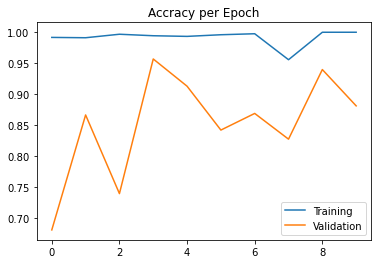

In [41]:
plt.title('Accracy per Epoch')
plt.plot(epochs, model_history.history['accuracy'], label='Training')
plt.plot(epochs, model_history.history['val_accuracy'], label='Validation')
plt.legend(loc='best')
plt.show()

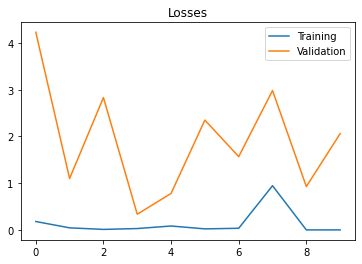

In [42]:
plt.title('Losses')
plt.plot(epochs, model_history.history['loss'], label='Training')
plt.plot(epochs, model_history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.show()